# Proyecto final: Clasificación de URLs maliciosas mediante red neuronal multicapa

En el notebook se describe cada parte del proyecto de manera resumida, véase el reporte para una descripción más completa.

In [106]:
# librerias necesarias
# Nota: ademas de las librerias listadas, es necesario instalar la libreria urllib con el comando pip install urllib

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Dataset

Antes de comenzar con el preprocesamiento de datos se realizó una corrección al dataset utilizado, dado que el dataset utilizado es en realidad una recopilación de distintos dataset, en Kaggle un usuario encontró un error donde las etiquetas de uno de los dataset originales (*phishstorm*) fueron invertidas, por lo que se descargó el dataset original y se realizó la corrección al dataset, el trabajo realizado se encuentra en la carpeta *correccion_dataset*.

De igual manera al realizar esta corrección se encontró un pequeño grupo de urls donde existía un error de codificación en el texto, por lo que se removieron manualmente.

El archivo resultante que se utiliza es *malicious_phish_updated.csv*

In [47]:
urls = pd.read_csv('malicious_phish_updated.csv')
urls

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651092,xbox360.ign.com/objects/850/850402.html,benign
651093,games.teamxbox.com/xbox-360/1860/Dead-Space/,benign
651094,www.gamespot.com/xbox360/action/deadspace/,benign
651095,en.wikipedia.org/wiki/Dead_Space_(video_game),benign


type
benign        428208
defacement     96457
phishing       93912
malware        32520
Name: count, dtype: int64


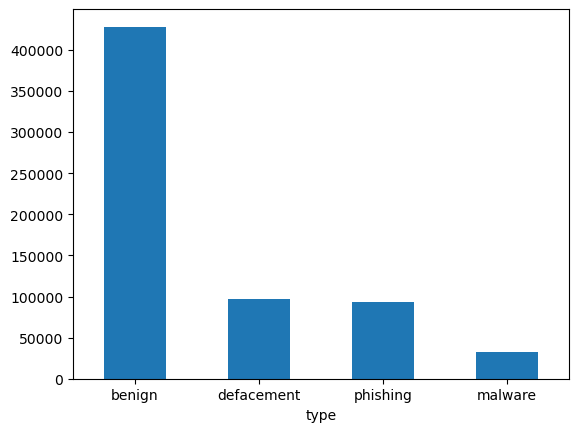

In [48]:
label_counts = urls['type'].value_counts()

print(label_counts)

label_counts.plot(kind='bar')
plt.xticks(rotation='horizontal')
plt.show()

# Preprocesamiento de datos

In [49]:
from urllib.parse import urlparse

## Balanceo de datos

Al tener datos significativamente desbalanceados, el reducir a la mitad la clase predominante (benign) ayuda de manera significativa al aprendizaje de la red.

type
benign        214104
defacement     96457
phishing       93912
malware        32520
Name: count, dtype: int64


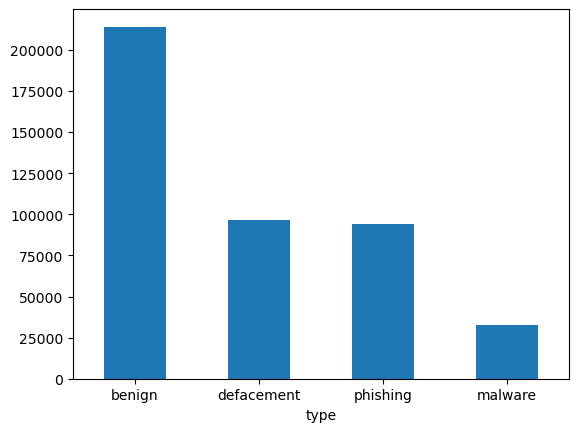

In [50]:
benign_rows = urls[urls['type'] == 'benign']
rows_to_drop = benign_rows.sample(frac=0.5)
urls = urls.drop(rows_to_drop.index)
urls.reset_index(drop=True)
urls = urls.reset_index(drop=True)

label_counts = urls['type'].value_counts()
print(label_counts)
label_counts.plot(kind='bar')
plt.xticks(rotation='horizontal')
plt.show()

En las siguientes celdas se procede a definir funciones para extraer características relevantes de cada URL de las cuales se hará uso para entrenar la red neuronal.

## Tamaño de URL

In [51]:
urls['length'] = urls['url'].apply(len)

## Densidad de vocales presentes en el URL

In [52]:
def calculate_vowel_density(url):
    vowels = 'aeiou'
    vowel_count = sum(1 for char in url if char.lower() in vowels)
    return vowel_count / len(url)

In [53]:
urls['vowel_density'] = urls['url'].apply(calculate_vowel_density)

## Densidad de consonantes presentes en el URL

In [54]:
def calculate_consonant_density(text):
    consonants = 'bcdfghjklmnpqrstvwxyz'
    consonant_count = sum(1 for char in text if char.lower() in consonants)
    return consonant_count / len(text)

In [55]:
urls['consonant_density'] = urls['url'].apply(calculate_consonant_density)

## Densidad de digitos presentes en el URL

In [56]:
def calculate_digit_density(url):
    digit_count = sum(1 for char in url if char.isdigit())  
    return digit_count / len(url)

In [57]:
urls['digit_density'] = urls['url'].apply(calculate_digit_density)

## Densidad de símbolos presentes en el URL

In [58]:
def calculate_symbol_density(url):
    symbol_count = sum(1 for char in url if not char.isalnum())
    return symbol_count / len(url)

In [59]:
urls['symbol_density'] = urls['url'].apply(calculate_symbol_density)

## Cantidad de vocales seguidas de una consonante

In [60]:
def vowel_consonant_density(url):
    vowels = 'aeiou'
    consonants = 'bcdfghjklmnpqrstvwxyz'
    pair_count = sum(1 for i in range(len(url) - 1) if url[i].lower() in vowels and url[i+1].lower() in consonants)
    return pair_count / len(url)

In [61]:
urls['vowel_consonant_pairs_density'] = urls['url'].apply(vowel_consonant_density)

## Cantidad de consonantes seguidas de vocales

In [62]:
def consonant_vowel_pairs_density(url):
    vowels = 'aeiou'
    consonants = 'bcdfghjklmnpqrstvwxyz'
    pair_count = sum(1 for i in range(len(url) - 1) if url[i].lower() in consonants and url[i+1].lower() in vowels)
    return pair_count / len(url)

In [63]:
urls['consonant_vowel_pairs_density'] = urls['url'].apply(consonant_vowel_pairs_density)

## Cantidad de vocales seguidas de vocales

In [64]:
def vowel_vowel_pairs_density(url):
    vowels = 'aeiou'
    pair_count = sum(1 for i in range(len(url) - 1) if url[i].lower() in vowels and url[i+1].lower() in vowels)
    return pair_count / len(url)

In [65]:
urls['vowel_vowel_pairs_density'] = urls['url'].apply(vowel_vowel_pairs_density)

## Cantidad de consonantes seguidas de consonantes

In [66]:
def consonant_consonant_pairs_density(url):
    consonants = 'bcdfghjklmnpqrstvwxyz'
    pair_count = sum(1 for i in range(len(url) - 1) if url[i].lower() in consonants and url[i+1].lower() in consonants)
    return pair_count / len(url)

In [67]:
urls['consonant_consonant_pairs_density'] = urls['url'].apply(consonant_consonant_pairs_density)

## Cantidad de dígitos seguidos de digitos

In [68]:
def digit_digit_pairs_density(url):
    pair_count = sum(1 for i in range(len(url) - 1) if url[i].isdigit() and url[i+1].isdigit())
    return pair_count / len(url) if url else 0

In [69]:
urls['digit_digit_pairs_density'] = urls['url'].apply(digit_digit_pairs_density)

## Contiene la cadena "www" o no

In [70]:
def has_www(url):
    return True if 'www' in url else False

In [71]:
urls['has_www'] = urls['url'].apply(has_www)

## Cantidad de mayúsculas

In [72]:
def capital_letter_density(url):
    capital_count = sum(1 for char in url if char.isupper())
    return capital_count / len(url) if url else 0

In [73]:
urls['capital_letter_density'] = urls['url'].apply(capital_letter_density)

## Tamaño del path

In [74]:
def count_subdirectories(url):
    return urlparse(url).path.count('/')


In [75]:
urls['subdirectories_count'] = urls['url'].apply(count_subdirectories)

## Número de consultas realizadas

In [76]:
def count_queries(url):
    return urlparse(url).query.count('=')

In [77]:
urls['query_count'] = urls['url'].apply(count_queries)

## Resultado de extracción de características

El dataframe resultante extrae 14 caracteríticas de cada URL:

In [40]:
urls

,url,type,length,vowel_density,consonant_density,digit_density,symbol_density,vowel_consonant_pairs_density,consonant_vowel_pairs_density,vowel_vowel_pairs_density,consonant_consonant_pairs_density,digit_digit_pairs_density,has_www,capital_letter_density,subdirectories_count,query_count
0,br-icloud.com.br,phishing,16,0.250000,0.562500,0.000000,0.187500,0.187500,0.125000,0.062500,0.187500,0.000000,False,0.000000,0,0
1,http://www.garage-pirenne.be/index.php?option=...,defacement,88,0.250000,0.465909,0.079545,0.204545,0.181818,0.181818,0.022727,0.170455,0.034091,True,0.000000,1,4
2,http://adventure-nicaragua.net/index.php?optio...,defacement,235,0.157447,0.689362,0.093617,0.059574,0.119149,0.102128,0.021277,0.472340,0.012766,False,0.268085,1,3
3,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,45,0.222222,0.466667,0.088889,0.222222,0.177778,0.177778,0.000000,0.155556,0.066667,False,0.000000,6,0
4,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,46,0.326087,0.543478,0.000000,0.130435,0.260870,0.260870,0.043478,0.173913,0.000000,False,0.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479809,psx.ign.com/articles/131/131835p1.html,benign,38,0.131579,0.447368,0.263158,0.157895,0.131579,0.078947,0.000000,0.210526,0.184211,False,0.000000,3,0
479810,xbox360.gamespy.com/xbox-360/dead-space/,benign,40,0.225000,0.450000,0.150000,0.175000,0.175000,0.200000,0.025000,0.125000,0.100000,False,0.000000,3,0
479811,games.teamxbox.com/xbox-360/1860/Dead-Space/,benign,44,0.250000,0.409091,0.159091,0.181818,0.181818,0.204545,0.045455,0.090909,0.113636,False,0.045455,4,0
479812,en.wikipedia.org/wiki/Dead_Space_(video_game),benign,45,0.400000,0.400000,0.000000,0.200000,0.222222,0.288889,0.066667,0.044444,0.000000,False,0.044444,2,0


# Creación de conjuntos de entrenamiento y prueba

El dataset se normaliza haciendo uso de MinMaxScaler, así todos los valores se encuentran en el rango [0,1]

In [78]:
scaler = MinMaxScaler()
x = pd.DataFrame (scaler.fit_transform(urls.drop(columns=['url', 'type'])))
x.columns = urls.columns[2:]
x = pd.concat([urls['url'],x], axis=1)
x

,url,length,vowel_density,consonant_density,digit_density,symbol_density,vowel_consonant_pairs_density,consonant_vowel_pairs_density,vowel_vowel_pairs_density,consonant_consonant_pairs_density,digit_digit_pairs_density,has_www,capital_letter_density,subdirectories_count,query_count
0,br-icloud.com.br,0.005069,0.375000,0.602679,0.000000,0.347506,0.412500,0.267857,0.137500,0.234375,0.000000,0.0,0.000000,0.000000,0.000000
1,bopsecrets.org/rexroth/cr/1.htm,0.011982,0.290323,0.656682,0.040860,0.295953,0.425806,0.345622,0.000000,0.362903,0.000000,0.0,0.000000,0.076923,0.000000
2,http://www.garage-pirenne.be/index.php?option=...,0.038249,0.375000,0.499188,0.100758,0.381033,0.400000,0.389610,0.050000,0.213068,0.045375,1.0,0.000000,0.025641,0.078431
3,http://adventure-nicaragua.net/index.php?optio...,0.105991,0.236170,0.738602,0.118582,0.095884,0.262128,0.218845,0.046809,0.590426,0.016991,0.0,0.286574,0.025641,0.058824
4,http://buzzfil.net/m/show-art/ils-etaient-loin...,0.052074,0.483051,0.499395,0.010734,0.378760,0.410169,0.399516,0.186441,0.180085,0.000000,0.0,0.000000,0.076923,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436988,wii.gamespy.com/wii/cursed-mountain/,0.014286,0.541667,0.505952,0.000000,0.306528,0.427778,0.535714,0.244444,0.138889,0.000000,0.0,0.000000,0.076923,0.000000
436989,wii.ign.com/objects/142/14270799.html,0.014747,0.243243,0.405405,0.376577,0.297668,0.237838,0.173745,0.059459,0.236486,0.323753,0.0,0.000000,0.076923,0.000000
436990,xbox360.gamespy.com/xbox-360/dead-space/,0.016129,0.337500,0.482143,0.190000,0.322919,0.385000,0.428571,0.055000,0.156250,0.133099,0.0,0.000000,0.076923,0.000000
436991,www.gamespot.com/xbox360/action/deadspace/,0.017051,0.428571,0.535714,0.090476,0.259696,0.471429,0.459184,0.104762,0.208333,0.063380,1.0,0.000000,0.102564,0.000000


In [79]:
y = urls[['type']].copy()

y

,type
0,phishing
1,benign
2,defacement
3,defacement
4,benign
...,...
436988,benign
436989,benign
436990,benign
436991,benign


Se cambian los valores de las etiquetas tal que:
- benign = 1
- defacement = 2
- phishing = 3
- malware = 4


In [80]:
category_mapping = {"benign": 1, "defacement": 2, "phishing": 3, "malware": 4}
y['type'] = y['type'].map(category_mapping)
#y = pd.concat([urls['url'],y], axis=1)
y

,type
0,3
1,1
2,2
3,2
4,1
...,...
436988,1
436989,1
436990,1
436991,1


Se obtienen los conjuntos de entrenamiento y prueba, el de entrenamiento abarca 70% de los datos y el de prueba 30%

In [81]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, shuffle=True, random_state=None)

Se utiliza OneHotEncoder para las etiquetas

In [82]:
y_train = OneHotEncoder().fit_transform(y_train).toarray()
y_test = OneHotEncoder().fit_transform(y_test).toarray()

y_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

Se obtienen los conjuntos de entrenamiento y prueba como tensores para poder utilizarlos con pytorch

In [83]:
x_train_tensor = torch.tensor(x_train.iloc[:, 1:].values, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test.iloc[:, 1:].values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [84]:
x_train_tensor = x_train_tensor.to(device)
x_test_tensor = x_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [48]:
x_train_tensor.shape, y_train_tensor.shape, y_test_tensor.shape, y_test_tensor.shape

(torch.Size([335869, 14]),
 torch.Size([335869, 4]),
 torch.Size([143945, 4]),
 torch.Size([143945, 4]))

# Red neuronal

Se define la clase Multilayer

In [93]:
class Multilayer(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(x_train_tensor.shape[1],50)
        self.hidden2 = nn.Linear(50,50)
        self.hidden3 = nn.Linear(50,25)
        self.output = nn.Linear(25,4)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.loss = nn.CrossEntropyLoss()
        self.history = []
        
    def forward(self,X):
        X = self.hidden1(X)
        X = self.relu(X)
        X = self.hidden2(X)
        X = self.relu(X)
        X = self.hidden3(X)
        X = self.relu(X)
        X = self.output(X)
        X = self.softmax(X)
        return X
    
    def track_progress(self, error):
        self.history.append(error.item())
    
    def back_propagate(self,X,Y):
        prediction = self.forward(X)
        error = self.loss(prediction,Y)
        self.zero_grad()
        error.backward()
        
    def train(self,train_X,train_Y,optimizer,epochs=100,verbose=False):
        for i in range(epochs):
            self.back_propagate(train_X,train_Y)
            optimizer.step()
            prediction = self.forward(train_X)
            error = self.loss(prediction,train_Y)
            self.track_progress(error)
            if verbose:
                print(f'Epoch [{i}], Error: {error.item()}')
    
    def confusion(self,test_X,test_Y):
        prediction = self.forward(test_X)
        matriz = confusion_matrix(np.argmax(test_Y.cpu().detach().numpy(), axis=1), np.argmax(prediction.cpu().detach().numpy(), axis=1))
        return matriz

## Entrenamiento de la red neuronal

In [94]:
from torch.optim import SGD
from torch.optim import Adam
from torch.optim import Adagrad

network = Multilayer().to(device)
optimizer = Adam(network.parameters(), lr=0.02)

In [95]:
torch.cuda.empty_cache() if torch.cuda.is_available() else None

In [ ]:
# train
network.train(x_train_tensor,y_train_tensor,optimizer,epochs=10000,verbose=True)

## Matriz de confusión y gráfica de error

Cada fila y columna corresponde a una clase, en la diagonal se encuentran las clasificadas correctamente en cada clase. El orden de las clases en la matriz de confusión es: benign, defacement, phishing y malware, de arriba hacia abajo y de izquierda a derecha.

[[62094   581  1402   154]
 [  637 27404   842    54]
 [ 6397  1723 19847   207]
 [  874   935   930  7017]]


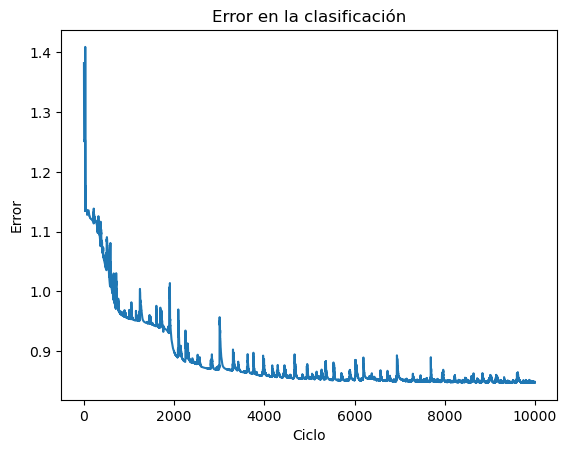

In [124]:
confusion = network.confusion(x_test_tensor,y_test_tensor)

print(confusion)

plt.plot(network.history)
plt.title('Error history')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

### Precisión en el conjunto de prueba

In [125]:
predictions = network(x_test_tensor).detach().cpu().numpy()
predictions = np.round(predictions).astype(int)
accuracy = accuracy_score(y_test, predictions)
print(f'Precision: {accuracy * 100}%')

Precision: 88.75497719263453%


## Visualización

### Predicción en conjunto de prueba

Se muestra un widget donde se puede seleccionar cualquier URL en el conjunto de prueba, al hacer click en el boton predict se muestra en texto la predicción de la red neuronal y su etiqueta con la clasificación correcta.

In [118]:
classes = ['benign', 'defacement', 'phishing', 'malware']
url_slider = widgets.SelectionSlider(options=x_test['url'].values, description='URLs:')
button_slider = widgets.Button(description='Predict')
output_slider = widgets.Output()

def on_button_clicked(b):
    url = url_slider.value
    url_data = [len(url), calculate_vowel_density(url), calculate_consonant_density(url), 
                calculate_digit_density(url), calculate_symbol_density(url),
                vowel_consonant_density(url), consonant_vowel_pairs_density(url),
                vowel_vowel_pairs_density(url), consonant_consonant_pairs_density(url),
                digit_digit_pairs_density(url), has_www(url), capital_letter_density(url),
                count_subdirectories(url), count_queries(url)]
    url_data_df = pd.DataFrame([url_data], columns=x.columns[1:])
    url_data = scaler.transform(url_data_df)
    url_data = torch.tensor(url_data, dtype=torch.float32)
    url_data = url_data.to(device)
    model_output = network(url_data)
    _, predicted = torch.max(model_output, 1)
    
    predicted_text = classes[predicted.item()]
    try:
        url_label_index = np.where(x_test['url'] == url)[0][0]
        label_text = classes[y_test[url_label_index].argmax()]
    except:
        label_text = 'Not found in test set'
    
    with output_slider:
        clear_output()
        print('Predicted: ', predicted_text)
        print('Label: ', label_text)
        
button_slider.on_click(on_button_clicked)
display(url_slider, button_slider, output_slider)


SelectionSlider(description='URLs:', options=('http://networktrendsnow.com/about-us/news/1-latest/40-admin', '…

Button(description='Predict', style=ButtonStyle())

Output()

### Predicción en input de usuario

Se muestra un widget con un recuadro donde el usuario puede ingresar texto y realizar una predicción, dado que se puede ingresar cualquier URL que no se incluya en el conjunto de prueba no se muestra una etiqueta con clasificación correcta en este caso.

In [119]:
classes = ['benign', 'defacement', 'phishing', 'malware']
url_box = widgets.Text(description='URL:')
button_box = widgets.Button(description='Predict')
output_box = widgets.Output()

def on_button_clicked(b):
    url = url_box.value
    url_data = [len(url), calculate_vowel_density(url), calculate_consonant_density(url), 
                calculate_digit_density(url), calculate_symbol_density(url),
                vowel_consonant_density(url), consonant_vowel_pairs_density(url),
                vowel_vowel_pairs_density(url), consonant_consonant_pairs_density(url),
                digit_digit_pairs_density(url), has_www(url), capital_letter_density(url),
                count_subdirectories(url), count_queries(url)]
    url_data_df = pd.DataFrame([url_data], columns=x.columns[1:])
    url_data = scaler.transform(url_data_df)
    url_data = torch.tensor(url_data, dtype=torch.float32)
    url_data = url_data.to(device)
    model_output = network(url_data)
    _, predicted = torch.max(model_output, 1)
    
    predicted_text = classes[predicted.item()]
    
    with output_box:
        clear_output()
        print('Predicted: ', predicted_text)
        
button_box.on_click(on_button_clicked)
display(url_box, button_box, output_box)

Text(value='', description='URL:')

Button(description='Predict', style=ButtonStyle())

Output()

# Conclusiones finales

Al finalizar varias pruebas con diferentes hiperparámetros se logró obtener una precisión en el conjunto de prueba de aproximadamente 88.75%, 
Las características de la red son:
- capas ocultas: 3 (50 neuronas, 50 neuronas y 25 neuronas)
- Funciones de activación para las capas ocultas: reLU
- Función de error: Cross Entropy

Los hiperparámetros utilizados fueron:
- Optimizador: Adam
- Learning rate: 0.02
- Épocas de entrenamiento: 10000

El entrenamiento se realizó haciendo uso de CUDA para optimizar los tiempos de entrenamiento, sin embargo, el entrenamiento mediante CPU no es excesivamente lento.

Es interesante notar que después de realizar pruebas con redes de mayores capas y neuronas (de 4 a 5 capas ocultas, +100 neuronas), estas no solo no obtenían mejores resultados, si no que incluso causaban que el entrenamiento se viera estancado en un punto donde el error dejaba de disminuir completamente.

Al realizar pruebas el optimizador Adam resultó más efectivo que SGD con gran diferencia, Adagrad obtuvo resultados solo ligeramente peores.

Es importante mencionar que para lograr que la red aprendiera de manera significativa los datos se balancearon de tal manera que la clase "benign" se redujo a la mitad, esto debido a que el desbalance original causaba que la red se quedara atorada y no obtuviera buenos resultados, pues únicamente aprendía a clasificar URLs como "benign". En general reducir la clase "benign" en mayor porcentaje al 50% puede significar una ligera mejora en los resultados, sin embargo, se buscó mantener tantos datos como fuera posible para no perder demasiada generalidad, con las pruebas realizadas intentar conservar más del 50% de la clase resultaba en dificultades importantes para entrenar la red.

Al realizar pruebas ingresando URLs no incluidas en el dataset se puede observar que la red puede llegar a no generalizar correctamente en URLs benignas cortas (google.com, x.com, etc.) y por lo tanto dar una clasificacióń erronea, por lo que probablemente para mejorar este aspecto será necesario recopilar más datos, sin embargo, realiza un buen trabajo cuando se trata de URLs más extensas y que en general pueden resultar más sospechosas a simple vista.